# EDM in one notebook

This notebook is a self-contained implementation of EDM specifically for toy 1D datasets. The deterministic algorithm (Algorithm 1) is implemented in its most general form, allowing the user to specify their choice of scaling and sigma functions for the any kind of EDM parameterisation. Furthermore, thanks to the use of autograd we can automatically compute derivatives over the scaling and sigma functions since they are required during sampling.

**Author:** Christopher Beckham, PhD (`first.last(at)mila(dot)quebec`)

**License:** this notebook is MIT (see `src/LICENSE_MIT`) except for the generalised stochastic sampler, which is specifically CC-NC-SA. Please see the comment on top of `src/edm_generalised_stochastic_sampler.py` for more details.

**Note:** this code has not been verified by the original paper authors and is mostly my own implementation, with some code borrowed from `k-diffusion`|. I do not offer any guarantees as to its correctness, fitness for purpose, or anything related to that nature.

In [28]:
import torch
from torch import nn 
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math

from functools import partial

from tqdm import trange

from IPython.display import display
from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2

In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [30]:
# Attribution: https://github.com/crowsonkb/k-diffusion/blob/master/k_diffusion/sampling.py#L17-L23
def get_sigmas_karras(n, sigma_min, sigma_max, rho=7., device='cpu'):
    """Constructs the noise schedule of Karras et al. (2022)."""
    ramp = torch.linspace(0, 1, n, device=device)
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
    return append_zero(sigmas).to(device)

In [31]:
import matplotlib.gridspec as gridspec

def plot_trajectory_v2(results, 
                       figsize=(8,5), 
                       plot2_ylim=(-1, 1),
                       kde = None,
                       kde_data=None,
                       alpha=0.25,
                       main_title=None,
                       debug=False):

    # Create a figure
    fig = plt.figure(figsize=figsize)

    # Define a GridSpec with 2 rows and 2 columns
    gs = gridspec.GridSpec(2, 2, height_ratios=[1.0, 0.5])  # height_ratios adjust the row heights
    
    traj = results[1]
    
    T = len(results[1])
    bs = len(results[0])
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    axes = [ax1,ax2]
    titles = ["trajectory", "trajectory (zoomed in)"]
    
    for ax_idx in range(2):
        if debug:
            print(f"length of trajectories: {len(results[1])}")
            print(f"length of samples: {len(results[1][0])}")
        # For each element
        traj = results[1]
        # traj[0][b], ... traj[-1][b]
        for b in range(bs):
            #print(b)
            #print(torch.stack([traj[t][b] for t in range(0,T) ]).cpu().numpy())
            axes[ax_idx].plot(
                torch.stack([traj[t][b] for t in range(0,T) ]).cpu().numpy(),
                c='orange',
                alpha=alpha
            )
        #axes[ax_idx].invert_xaxis()
        axes[ax_idx].set_xlabel('$t$')
        axes[ax_idx].set_ylabel('$p(x_t)$')
        axes[ax_idx].set_title(titles[ax_idx])
        if ax_idx == 1:
            axes[ax_idx].set_ylim(*plot2_ylim)
        axes[ax_idx].scatter([T-1]*len(dataset), dataset[:,0].cpu().numpy(), s=0.9)
        axes[ax_idx].grid()
        # reverse the x axis ticks as well
        axes[ax_idx].set_xticklabels(axes[ax_idx].get_xticks()[::-1])
    
    # Bottom row, one plot spanning across both columns
    samples = results[0].cpu().numpy()
    if debug:
        print("len samples:", len(samples))
    
    ax3 = fig.add_subplot(gs[1, :])
    # histogram the fake samples
    ax3.hist(samples, bins=100, density=True, color='orange')
    # plot the kde data if given
    mean_ll = None
    if kde_data is not None:
        ax3.plot(kde_data[0], kde_data[1], color='blue', lw=2)
        if kde is not None:
            mean_ll = np.mean(kde.pdf(samples.flatten()))
    if mean_ll is None:
        ax3.set_title("histogram, real vs generated samples")
    else:
        ax3.set_title(f"histogram, real vs generated samples (mean ll={mean_ll:.3f})")
    ax3.legend(['kde(dataset)', 'samples'])
    ax3.grid()
    
    if main_title is not None:
        fig.suptitle(main_title)

    # Adjust layout to avoid overlap
    fig.tight_layout()
    
    return fig

## Network architecture

In [32]:
#%pip install random-fourier-features-pytorch
from rff.layers import PositionalEncoding

In [33]:
#import torchvision

In [34]:
class Denoiser(nn.Module):
    def __init__(self, n_in, n_layers=5, n_h=16):
        super().__init__()
        self.mods = []
        self.pos = PositionalEncoding(1.0, n_h // 2)
        for j in range(n_layers):
            if j == 0:
                this_nin = n_in + n_h
            else:
                this_nin = n_h * 2
            if j != n_layers-1:
                self.mods.append(nn.Sequential(
                    nn.Linear(this_nin, n_h),
                    nn.LayerNorm(n_h),
                    nn.ReLU()
                ))
            else:
                self.mods.append(
                    nn.Linear(this_nin, n_in)
                )
        self.mods = nn.ModuleList(self.mods)
    def forward(self, x, s):
        if len(s.shape) == 1:
            s = s.view(-1, 1)
        #h = self.pos(x)
        h = torch.cat((x, self.pos(x)), dim=1)
        for b,module in enumerate(self.mods):
            #print(">>", h.shape)
            if b==0:
                h = module(h)
            else:
                hs = torch.cat((h, self.pos(s)), dim=1)
                h = module(hs)
        return h

## Prepare data

In [35]:
dataset = torch.cat((
    torch.randn((1000, 1)).normal_(-1, 0.1),
    torch.randn((1000, 1)).normal_(+1, 0.1)
))

In [36]:
ds = TensorDataset(dataset)

In [37]:
loader = DataLoader(ds, shuffle=True, batch_size=64)

## Samplers

Attribution: https://github.com/crowsonkb/k-diffusion/blob/master/k_diffusion/sampling.py

In [38]:
@torch.no_grad()
def sample_euler(model, x, sigmas, extra_args=None, callback=None, disable=None, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.):
    """Implements Algorithm 2 (Euler steps) from Karras et al. (2022).
    """
    extra_args = {} if extra_args is None else extra_args
    s_in = x.new_ones([x.shape[0]])
    trajectory = []
    for i in trange(len(sigmas) - 1, disable=disable):
        gamma = min(s_churn / (len(sigmas) - 1), 2 ** 0.5 - 1) if s_tmin <= sigmas[i] <= s_tmax else 0.
        sigma_hat = sigmas[i] * (gamma + 1)
        if gamma > 0:
            print("gamma > 0")
            eps = torch.randn_like(x) * s_noise
            x = x + eps * (sigma_hat ** 2 - sigmas[i] ** 2) ** 0.5
        denoised = model(x, sigma_hat * s_in, **extra_args)
        d = to_d(x, sigma_hat, denoised)
        print(f"{i} {x.shape} {sigma_hat.shape} {sigma_hat} : {denoised.shape}", "{:.3f}".format((d**2).mean()))
        if callback is not None:
            callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigma_hat, 'denoised': denoised})
        #dt = sigmas[i + 1] - sigma_hat
        # NOTE: I change the order of the terms in dt here to make it +ve, this also means
        # the derivative in `to_d` must be `(denoised-x)/sigma`, this is a stylistic decision
        # because I find the original code produces a double negation, which is hardly readable.
        dt = sigma_hat - sigmas[i+1]
        if i == 0:
            print("dt:", dt)
        #print(dt)
        # Euler method
        x = x + d * dt
        trajectory.append(x)
    return x, trajectory

In [39]:
def to_d(x, sigma, denoised):
    """Converts a denoiser output to a Karras ODE derivative."""
    return (denoised-x) / append_dims(sigma, x.ndim)

In [40]:
def append_dims(x, target_dims):
    """Appends dimensions to the end of a tensor until it has target_dims dimensions."""
    dims_to_append = target_dims - x.ndim
    if dims_to_append < 0:
        raise ValueError(f'input has {x.ndim} dims but target_dims is {target_dims}, which is less')
    return x[(...,) + (None,) * dims_to_append]

In [41]:
def append_zero(x):
    return torch.cat([x, x.new_zeros([1])])

### generalised sampler

This is EDM's Algorithm 1, which is deterministic sampling using Heun's 2nd order method. While the original code also presents a somewhat general form of the [algorithm](https://github.com/NVlabs/edm/blob/main/generate.py#L66-L72), this one lets you specify arbitrary $\sigma(t)$ and $s(t)$. Furthermore, the derivatives of these functions do not have to be defined -- we let autograd do that for us.

In [42]:
from torch.autograd import grad

def edm_generalised_deterministic_sampler(
    model, 
    x, 
    timesteps,
    extra_args=None, 
    callback=None, 
    disable=None, 
    sigma_fn        = lambda t: t*1.0,
    s_fn            = lambda t: t*0 + 1,
    #s_churn: float  = 0., 
    #s_tmin: float   = 0., 
    #s_tmax: float   = float('inf'), 
    #s_noise: float  = 1.,
    debug: bool = False,
    use_heun: bool = True,
):
    
    t = timesteps
    
    extra_args = {} if extra_args is None else extra_args
    s_in = x.new_ones([x.shape[0]])
    trajectory = []
    for i in trange(len(timesteps) - 1, disable=disable):
        
        ti = (t[i]*s_in).view(-1, 1)
        ti.requires_grad = True
        
        dot_sigma_fn_ti = grad(sigma_fn(ti).sum(), ti)[0]
        dot_s_fn_ti = grad(s_fn(ti).sum(), ti)[0]
        
        if use_heun:
            tip1 = (t[i+1]*s_in).view(-1, 1)
            tip1.requires_grad = True
            dot_sigma_fn_tip1 = grad(sigma_fn(tip1).sum(), tip1)[0]
            dot_s_fn_tip1 = grad(s_fn(tip1).sum(), tip1)[0]
        
        with torch.no_grad():
        
            denoised = model(x / s_fn(ti), sigma_fn(ti), **extra_args)

            d = ( (dot_sigma_fn_ti / sigma_fn(ti)) + (dot_s_fn_ti / s_fn(ti)) ) * x - \
                ( dot_sigma_fn_ti * s_fn(ti) / sigma_fn(ti) ) * denoised

            # before: denoised-x and +ve dt
            # this is x-denoised and -ve dt

            if debug:
                print(f"{i} {x.shape} {sigma_fn(ti).shape} {sigma_fn(ti)[0]} : {denoised.shape}", "{:.3f}".format((d**2).mean()))
            if callback is not None:
                callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigma_hat, 'denoised': denoised})

            dt = t[i+1] - t[i]
            if i==0 and debug:
                print(dt)
            
            # Take Euler step
            x = x + dt*d
            
            if use_heun and sigma_fn(tip1)[0].item() != 0:
                denoised2 = model(x / s_fn(tip1), sigma_fn(tip1), **extra_args)
                d2 = ( (dot_sigma_fn_tip1 / sigma_fn(tip1)) + (dot_s_fn_tip1 / s_fn(tip1)) ) * x - \
                     ( dot_sigma_fn_tip1 * s_fn(tip1) / sigma_fn(tip1) ) * denoised2
                x = x + dt*(0.5*d + 0.5*d2)
            #else:
            #    print("we hit 0", sigma_fn(tip1))
            
            trajectory.append(x)
            
    return x, trajectory

In [100]:
# NOTE: this code is under a different license, please see top  of src/edm_generalised_stochastic_sampler.py
# for more details.
from src.edm_generalised_stochastic_sampler import edm_generalised_stochastic_sampler

## Dataset

Our dataset is a simple bi-modal Gaussian dataset

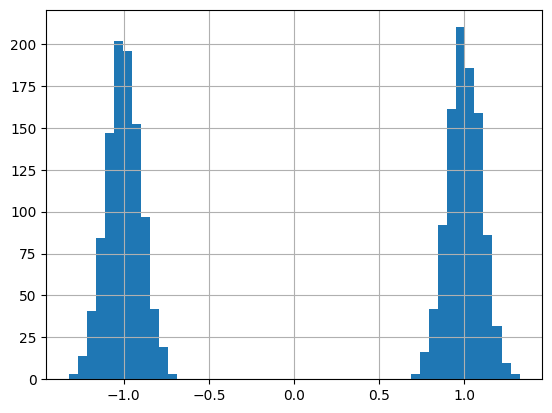

In [19]:
_=plt.hist( dataset[:,0].numpy(), bins=50)
plt.grid()

## Training

In [162]:
#%pip install random-fourier-features-pytorch

In [20]:
sigmas = get_sigmas_karras(100, 0.02, 10.0)[0:-1] # don't include sigma=0 for now

In [21]:
len(sigmas)

100

In [22]:
# This weighting function heavily weights sigma values close to zero.
sigma_weight = lambda s: (s**2 + 0.5**2) / (s * 0.5)**2

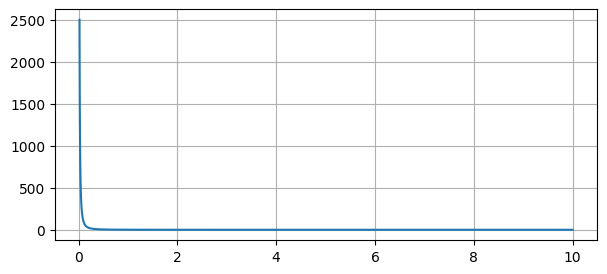

In [23]:
plt.figure(figsize=(7,3))
plt.plot(sigmas, sigma_weight(sigmas))
plt.grid()

In [44]:
class EdmWrapper(nn.Module):
    def __init__(
        self, 
        net,
        sigma_data: float = 0.5,
        # These fns take a `sigma` and `sd` which is the assumed stdev of the data
        c_skip            = lambda sigma, sd: sd**2 / (sigma**2 + sd**2),
        c_out             = lambda sigma, sd: sigma*sd / (sd**2 + sigma**2)**0.5,
        c_in              = lambda sigma, sd: 1. / (sigma**2 + sd**2)**0.5,
        c_noise           = lambda sigma, sd: 0.25 * torch.log(sigma),
        weight_fn         = lambda sigma, sd: (sigma**2 + sd**2) / (sigma * 0.5)**2
    ):
                 
        super().__init__()
        self.c_skip =  partial(c_skip, sd=sigma_data)
        self.c_out = partial(c_out, sd=sigma_data)
        self.c_in = partial(c_in, sd=sigma_data)
        self.c_noise = partial(c_noise, sd=sigma_data)
        self.weight_fn = partial(weight_fn, sd=sigma_data)
        self.net = net
    def forward(self, x, s):
        if len(s.shape) == 1:
            s = s.view(-1, 1)
        d_out = self.c_skip(s)*x + self.c_out(s)*self.net( self.c_in(s)*x, self.c_noise(s) )
        return d_out

- VP sampler
  - $\sigma^{-1}(\sigma) \sim U(\epsilon_t, 1)$ so basically the timestep $t \sim U(\epsilon_t, 1)$
  - we can just use a beta to sigma here

### Noise distributions

This determines the sampling distribution of $\sigma$ during training.

In [45]:
def ve_sampler(N, sigma_min, sigma_max):
    """ln(sigma) ~ U(ln(sigma_min), ln(sigma_max))"""
    return torch.from_numpy(np.exp(
        np.random.uniform(np.log(sigma_min), np.log(sigma_max), size=(N,))
    ))

In [46]:
def vp_sampler(N, b_d, b_min, eps_t=10e-5):
    """This one is 'special', EDM Table 1 calls it sigma_inv(sigma) ~ U(e_t, 1),
    so basically the raw timesteps are distributed according to `t ~ U(e_t, 1)`.
    
    But since we want to be consistent in using sigmas for preconditioning, we
    need to use the sigma(t) function from the "Sampling" part of the table.
    
    Also,
    """
    t = torch.randn((N,)).uniform_(eps_t, 1)
    return torch.sqrt(torch.exp(0.5*b_d*(t**2) + b_min*t)-1)

In [47]:
def edm_sampler(N, P_mean, P_std):
    return torch.exp(torch.randn((N,)).normal_(P_mean, P_std))

In [48]:
#ts = torch.randn((100,)).uniform_(10**-3, 1)
#tmp = torch.sqrt(torch.exp(0.5*b_d*(ts**2) + b_min*ts)-1)
#plt.scatter(ts,tmp)

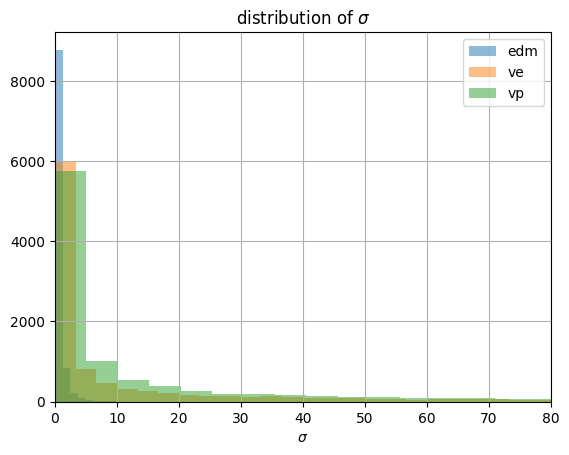

In [49]:
plt.hist(edm_sampler(10000, P_mean=-1.2, P_std=1.2).numpy(), bins=30, alpha=0.5)
plt.hist(ve_sampler(10000, sigma_min=0.02, sigma_max=100).numpy(), bins=30,alpha=0.5)
plt.hist(vp_sampler(10000, b_d=19.9, b_min=0.1).numpy(), bins=30,alpha=0.5)
plt.xlim(0,80)
plt.title('distribution of $\sigma$')
plt.legend(['edm', 've', 'vp'])
plt.xlabel('$\sigma$')
plt.grid()

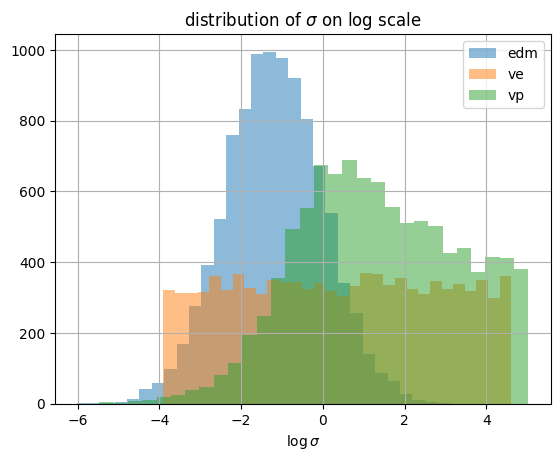

In [29]:
plt.hist(np.log(edm_sampler(10000, P_mean=-1.2, P_std=1.2).numpy()), bins=30, alpha=0.5)
plt.hist(np.log(ve_sampler(10000, sigma_min=0.02, sigma_max=100).numpy()), bins=30, alpha=0.5)
plt.hist(np.log(vp_sampler(10000, b_d=19.9, b_min=0.1).numpy()), bins=30, alpha=0.5)
#plt.xlim(0,80)
plt.title('distribution of $\sigma$ on log scale')
plt.legend(['edm', 've', 'vp'])
plt.xlabel('$\log \sigma$')
plt.grid()

### Hyperparameters

Paraphrasing from EDM Table 1:
- **Variance Preserving (VP):**
  - $c_{\text{skip}}(\sigma) = 1$
  - $c_{\text{out}}(\sigma) = -\sigma$
  - $c_{\text{in}}(\sigma) = 1 / \sqrt(\sigma^2 + 1)$
  - $c_{\text{noise}}(\sigma) = (M-1)\sigma^{-1}(\sigma)$ (for $M=1000$), so really we invert the sigma to convert back to continuous timesteps in $[0,1]$ and then map it to the range $[0,999]$). This is kind of a pain in the butt to implement in my code so I just redef it to $\sigma$.
  - noise distribution: see
- **Variance Exploding (VE):**
  - $c_{\text{skip}}(\sigma) = 1$
  - $c_{\text{out}}(\sigma) = \sigma$
  - $c_{\text{in}}(\sigma) = 1$
  - $c_{\text{noise}}(\sigma) = \log(0.5\sigma)$
- **EDM:**
  - $c_{\text{skip}}(\sigma) = \sigma_d^2 / (\sigma^2 + \sigma_d^2)$
  - $c_{\text{out}}(\sigma) = \sigma \cdot \sigma_d / \sqrt{\sigma_d^2 + \sigma^2}$
  - $c_{\text{in}}(\sigma) = 1 / \sqrt{\sigma^2 + \sigma_d^2}$
  - $c_{\text{noise}}(\sigma) = \frac{1}{4} \log(\sigma)$
  
Specific to these experiments:
- I use the same MLP architecture so matter what the SDE is
- $\sigma_{\text{min}} = 0.02$ and $\sigma_{\text{max}} = 10.0$ for all SDEs. Note: for EDM, even though I use the default sampling distribution $\log(\sigma) \sim \mathcal{N}(-1.2, 1.2)$ (which can sample a value of $\sigma >> 10$), I found no issues starting with $\sigma_{\text{max}} = 10.0$ during actual sampling.

In [50]:
def get_model(option, weights_file=None):
    print(f"choosing hps for configuration {option} ...")
    F_net = Denoiser(1, 5, 1024)
    if option == 've':
        D = EdmWrapper(
            F_net,
            c_skip    = lambda sigma, sd: sigma*0 + 1,           # c_skip(sigma) = 1
            c_out     = lambda sigma, sd: sigma,                 # c_out(sigma) = sigma
            c_in      = lambda sigma, sd: sigma*0 + 1,           # c_in(sigma) = 1,
            c_noise   = lambda sigma, sd: torch.log(0.5*sigma),  # c_noise(sigma) = ln(0.5*sigma),
            weight_fn = lambda sigma, sd: 1.0 / sigma**2         # lambda(sigma) = 1/sigma**2
        )
    elif option == 'vp':
        D = EdmWrapper(
            F_net,
            c_skip    = lambda sigma, sd: sigma*0 + 1,                    # c_skip(sigma) = 1
            c_out     = lambda sigma, sd: -sigma,                         # c_out(sigma) = -sigma
            c_in      = lambda sigma, sd: 1. / torch.sqrt(sigma**2 + 1),  # c_in(sigma) = 1 / sqrt(sigma**2 + 1)
            # this is intentionally wrong, it's just a pain in the ass to
            # re-do my api to pass in a timestep instead.
            c_noise   = lambda sigma, sd: sigma,                          # c_noise(sigma) = (M-1)*t,
            weight_fn = lambda sigma, sd: 1.0 / sigma**2                  # lambda(sigma) = 1/sigma**2
        )
    elif option == 'edm':
        D = EdmWrapper(F_net)
    else:
        raise ValueError(f"option {option} unknown")
    D.option = option
    D = D.cuda()
    if weights_file is not None:
        print(D.load_state_dict(torch.load(weights_file)))
    return D

In [83]:
D = get_model('vp')

choosing hps for configuration vp ...


In [165]:
opt = optim.Adam(D.parameters(), lr=2e-4)

We also need to specify the sampling distribution.

In [86]:
def get_sampler_sigma(option):
    if option == 've':
        sampler = partial(ve_sampler, sigma_min=0.02, sigma_max=10.)
    elif option == 'vp':
        sampler = partial(vp_sampler, b_d=19.9, b_min=0.1)
    elif option == 'edm':
        sampler = partial(edm_sampler, P_mean=-1.2, P_std=1.2)
    else:
        raise ValueError(f"sampler not recognised {option}")
    return sampler

In [88]:
for form in ['ve', 'vp', 'edm']:
    
    D = get_model('vp')
    opt = optim.Adam(D.parameters(), lr=2e-4)
    sampler = get_sampler_sigma(D.option)

    print(f"training D assuming variant={D.option} ...")
    
    kill_train = False
    n_epochs = 10000 # 10000
    for epoch in range(n_epochs):
        D.train()
        losses = []
        for xb in loader:
            opt.zero_grad()
            xb = xb[0].cuda()
            bs = xb.size(0)
            #this_sigmas = sigmas[rnd_idcs]
            #this_sigmas = this_sigmas.view(-1, 1).cuda()
            this_sigmas = sampler(bs).view(-1, 1).float().cuda()
            xb_noised = xb + torch.randn_like(xb)*this_sigmas
            this_denoised = D(xb_noised, this_sigmas)
            loss = torch.mean( D.weight_fn(this_sigmas) * (this_denoised-xb)**2 )
            #loss = torch.mean( (this_denoised-xb)**2 )
            if torch.isnan(loss).item():
                print(D.weight_fn(this_sigmas))
                kill_train = True
                break
            #loss = torch.mean( (this_denoised-xb)**2 )
            loss.backward()
            losses.append(loss.item())
            opt.step()
        if kill_train:
            print("killing...")
            break
        if epoch % 100 == 0:
            print(f"{epoch} - loss mean = {np.mean(losses):.3f}, loss std = {np.std(losses):.3f}")
    print("saving chkpt...")
    torch.save(D.state_dict(), "weights/d_{}.pt".format(form)) # weights

choosing hps for configuration vp ...
training D assuming variant=vp ...
0 - loss mean = 1.226, loss std = 0.644
saving chkpt...
choosing hps for configuration vp ...
training D assuming variant=vp ...
0 - loss mean = 1.385, loss std = 0.944
saving chkpt...
choosing hps for configuration vp ...
training D assuming variant=vp ...
0 - loss mean = 1.623, loss std = 1.338
saving chkpt...


------

## Generation

Let's first start off by doing some generations with the EDM model.

In [93]:
D = get_model(option="edm", weights_file="weights/d_{}.pt".format("edm"))
D.eval()

choosing hps for configuration edm ...
<All keys matched successfully>


/tmp/ipykernel_3348668/1586971115.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(D.load_state_dict(torch.load(weights_file)))


EdmWrapper(
  (net): Denoiser(
    (pos): PositionalEncoding()
    (mods): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=1025, out_features=1024, bias=True)
        (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (2): ReLU()
      )
      (1-3): 3 x Sequential(
        (0): Linear(in_features=2048, out_features=1024, bias=True)
        (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (2): ReLU()
      )
      (4): Linear(in_features=2048, out_features=1, bias=True)
    )
  )
)

We need to define the function which spits out the timesteps $\{t_0, t_1, \dots, t_N\}$ to be used by the sampler.

In [63]:
def get_timesteps_edm(N, sigma_min, sigma_max, rho=8.0):
    """See Table 1 of EDM paper"""
    return [(
        sigma_max**(1/rho) + (i/(N-1))*(sigma_min**(1/rho) - sigma_max**(1/rho))
    )**(rho) for i in range(N) ]

def get_timesteps_ve(N, s_min, s_max):
    """See Table 1 of EDM paper"""
    return [ ((s_max**2 * (s_min**2 / s_max**2))**(i/(N-1))) for i in range(N) ]

def get_timesteps_vp(N, eps_s=10**-3):
    """See Table 1 of EDM paper"""
    return [(1 + (i/(N-1))*(eps_s-1)) for i in range(N)]

In [64]:
from torch.autograd import grad

The sequence of timesteps is denoted $\{t_0, t_1, \dots, t_N\}$ a sequence of monotonically decreasing values where $t_N = 0$. Each $t_i \in \mathbb{R}^+$.

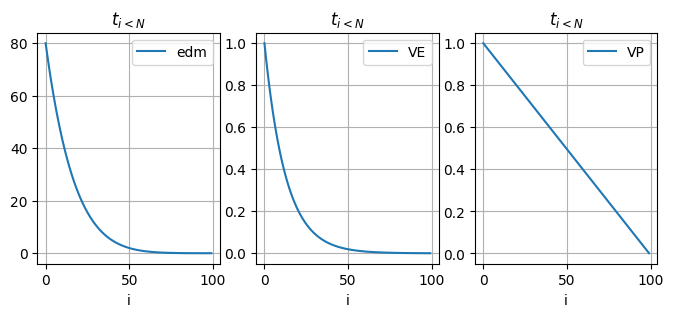

In [26]:
#plt.plot(get_timesteps_edm(100, 0.002, 80))
fig, axes = plt.subplots(1,3, figsize=(8,3))
axes = axes.flatten()
axes[0].plot(get_timesteps_edm(100, 0.002, 80))
axes[0].legend(['edm'])
axes[1].plot(get_timesteps_ve(100, 0.02, 100))
axes[1].legend(['VE'])
axes[2].plot(get_timesteps_vp(100))
axes[2].legend(['VP'])
for j in range(3):
    axes[j].set_title('$t_{i < N}$')
    axes[j].set_xlabel('i')
    axes[j].grid()

For the generalised EDM sampler (which is literally just the paper's Algorithm 1), we can specify the scheduling function $\sigma(t)$ as well as the scaling function $s(t)$. Algorithm 1 also requires the derivatives of both these functions but they will be computed automagically with autograd.

In [113]:
#get_timesteps_edm(N=100, sigma_min=0.002, sigma_max=10.)

In [65]:
# Run the ODE for T=100 timesteps.
results_edm = []
for use_heun in [True, False]:
    results_edm_heun = edm_generalised_deterministic_sampler(
        D, 
        # During EDM training we sample ln \sigma ~ N(-1.2, 1.2), setting \sigma_T = 10
        # seems reasonable here.
        x        = torch.randn((512,1)).normal_(0, 10.).cuda(), 
        timesteps= get_timesteps_edm(N=100, sigma_min=0.002, sigma_max=10.) + [0.],
        sigma_fn = lambda t: t*1.0,
        s_fn     = lambda t: t*0 + 1,     # don't use ones_like here since we need autograd to work,
        use_heun=use_heun,
    )
    results_edm.append(results_edm_heun)

Let's first compute a KDE over the dataset. This will come in handy so that we can also overlay it over our samples when we run the plotting fn.

In [66]:
from scipy.stats import gaussian_kde

dataset_1d_np = dataset.numpy().flatten()
kde = gaussian_kde(dataset_1d_np)
kde_xvals = np.linspace(min(dataset_1d_np), max(dataset_1d_np), 50)
kde_yvals = kde(kde_xvals)

/tmp/ipykernel_3348668/1095155476.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[ax_idx].set_xticklabels(axes[ax_idx].get_xticks()[::-1])


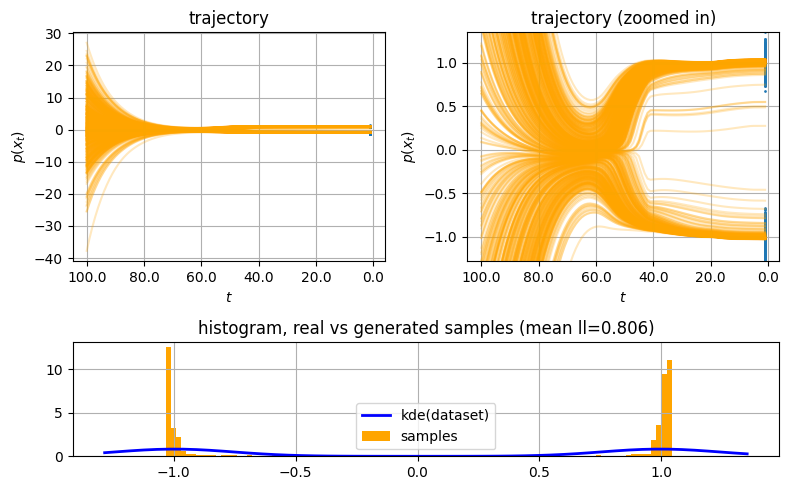

In [67]:
_=plot_trajectory_v2(
    results_edm[0], # with heun 
    plot2_ylim=(dataset.min(), dataset.max()),
    kde_data=(kde_xvals, kde_yvals),
    kde=kde
)

/tmp/ipykernel_3348668/1095155476.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[ax_idx].set_xticklabels(axes[ax_idx].get_xticks()[::-1])


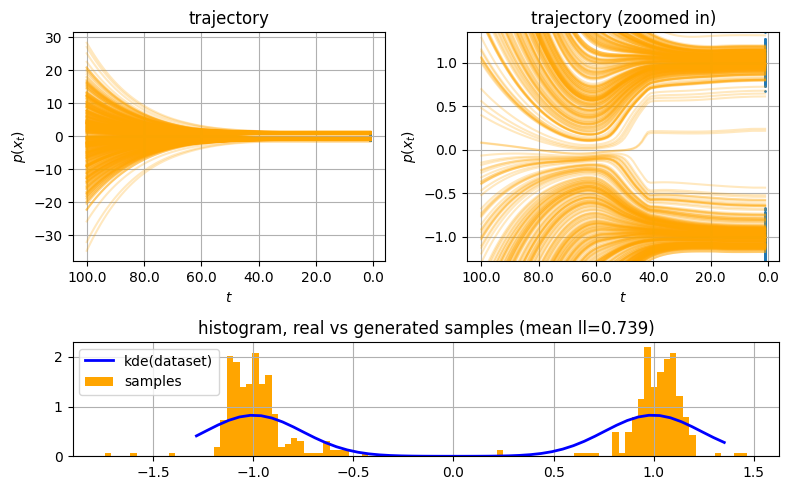

In [68]:
_=plot_trajectory_v2(
    results_edm[1], # without heun 
    plot2_ylim=(dataset.min(), dataset.max()),
    kde_data=(kde_xvals, kde_yvals),
    kde=kde
)

Ok great, we can see that with Heun sampling enabled we get a much better KDE likelihood. From now on, let's just leave Heun enabled.

We can also try the stochastic sampler. However, it appears from the paper that they only evaluated this on the VE and VP variants (see Table 5 appendix). We can still try it here just to see the stochasticity in action. (Please note that this specific method, `edm_generalised_stochastic_sampler`, lives in its own file in `src/` and is under a different license. Please see the top of that file for more details.)

In [98]:
results_edm_stoch = edm_generalised_stochastic_sampler(
    D, 
    # During EDM training we sample ln \sigma ~ N(-1.2, 1.2), setting \sigma_T = 10
    # seems reasonable here.
    x        = torch.randn((512,1)).normal_(0, 10.).cuda(), 
    timesteps= get_timesteps_edm(N=100, sigma_min=0.002, sigma_max=10.) + [0.],
    sigma_fn = lambda t: t*1.0,
    s_fn     = lambda t: t*0 + 1,     # don't use ones_like here since we need autograd to work,
    use_heun = False,

    #s_churn=5,
    stochastic = True, # defaults to True
    s_churn  = 1,
    # [S_max,S_min] encompasses the entire noise schedule so noise gets injected everywhere
    s_tmin   = 0.,
    s_tmax   = 10,
    s_noise  = 1.007,
    
    debug=0
)

/tmp/ipykernel_3348668/1095155476.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[ax_idx].set_xticklabels(axes[ax_idx].get_xticks()[::-1])


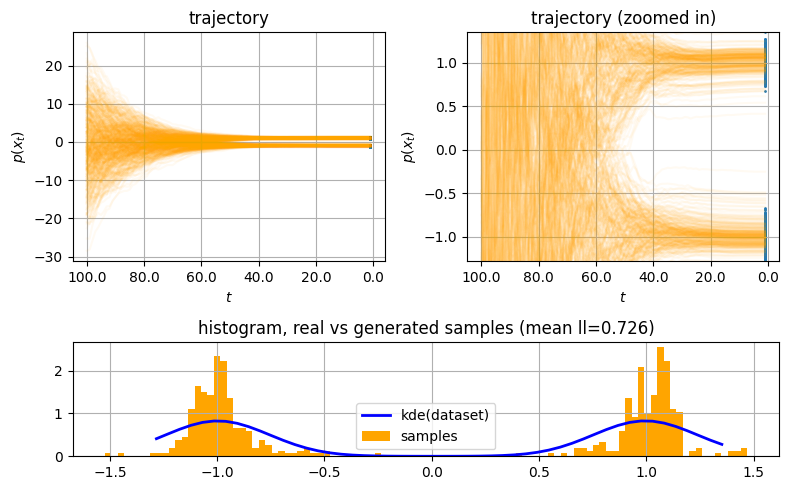

In [99]:
_=plot_trajectory_v2(
    results_edm_stoch,
    plot2_ylim=(dataset.min(), dataset.max()),
    kde_data=(kde_xvals, kde_yvals),
    kde=kde,
    alpha=0.05
)

Here, we will also generate samples from the same model but assume the VE and VP style of sampling. Again, see Table 1 of the original paper for more details.

In [43]:
results_ve = edm_generalised_deterministic_sampler(
    D,
    x          = torch.randn((512,1)).normal_(0, 10).cuda(), 
    timesteps  = get_timesteps_ve(N=100, s_min=0.02, s_max=10.),
    sigma_fn   = lambda t: torch.sqrt(t),
    s_fn       = lambda t: t*0 + 1     # don't use ones_like here
)

/tmp/ipykernel_411642/1095155476.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[ax_idx].set_xticklabels(axes[ax_idx].get_xticks()[::-1])


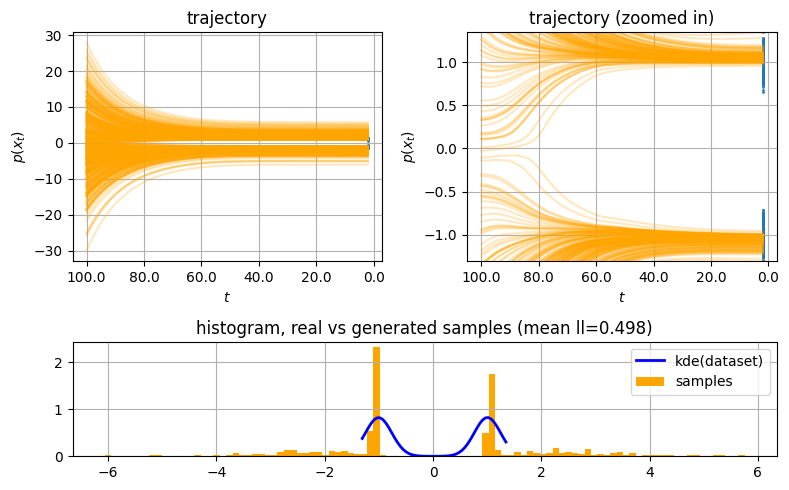

In [44]:
_=plot_trajectory_v2(results_ve, 
                   plot2_ylim=(dataset.min(), dataset.max()),
                   kde_data=(kde_xvals, kde_yvals),
                   kde=kde)

In [45]:
def timesteps_vp(N, eps=10e-3):
    return [ (1 + (i / (N-1))*(eps-1)) for i in range(N) ]

In [46]:
b_d, b_min = 19.9, 0.1
results_vp = edm_generalised_deterministic_sampler(
    D, 
    x          = torch.randn((512,1)).normal_(0, 10).cuda(), 
    timesteps  = get_timesteps_vp(N=100),
    sigma_fn   = lambda t: torch.sqrt(torch.exp(0.5*b_d*(t**2) + b_min*t)-1),
    s_fn       = lambda t: 1.0 / torch.sqrt(torch.exp(0.5*b_d*(t**2) + b_min*t)),
    debug=False
)

/tmp/ipykernel_411642/1095155476.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[ax_idx].set_xticklabels(axes[ax_idx].get_xticks()[::-1])


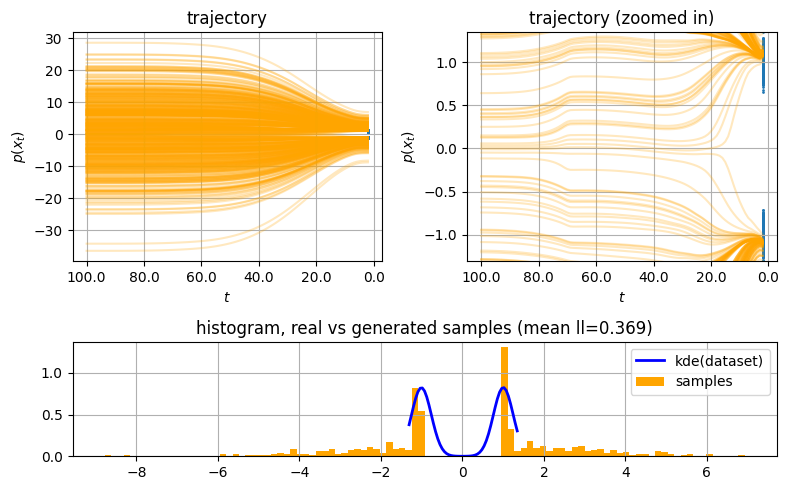

In [47]:
_=plot_trajectory_v2(results_vp, 
                   plot2_ylim=(dataset.min(), dataset.max()),
                   kde_data=(kde_xvals, kde_yvals),
                   kde=kde)

In [112]:
#results = sample_euler(D, x, sigmas.cuda())

### Examining other models

processing ve ...
choosing hps for configuration ve ...
<All keys matched successfully>
************************
  testing EDM sampler...
************************


/tmp/ipykernel_411642/1586971115.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(D.load_state_dict(torch.load(weights_file)))
/tmp/ipykernel_411642/1095155476.py:

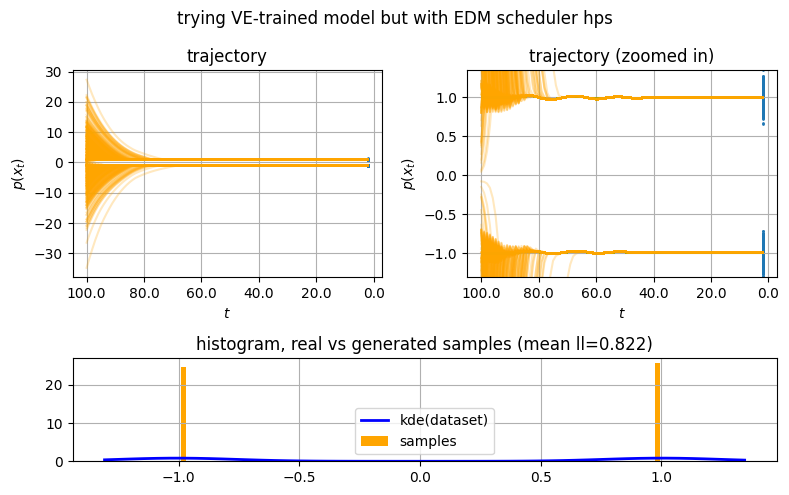

************************
  testing VE sampler...
************************


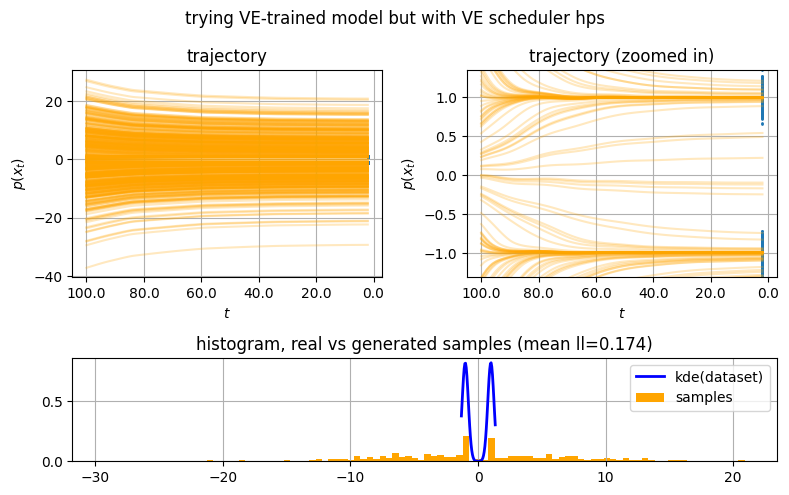

************************
  testing VP sampler...
************************


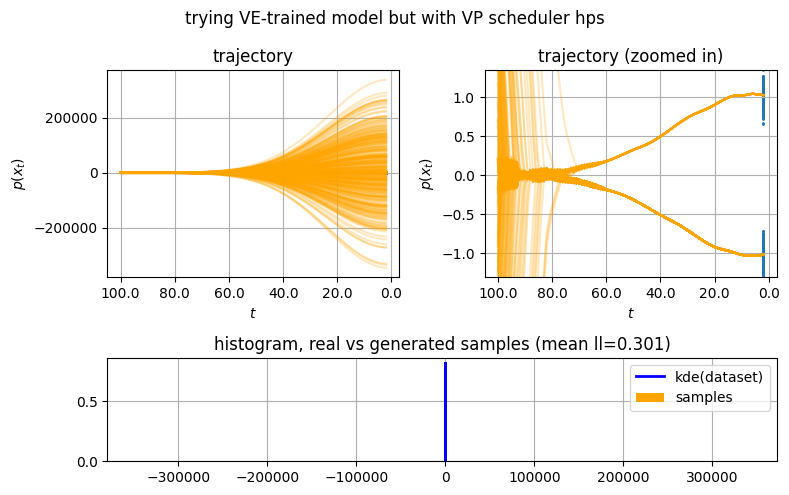

-----------------------------------
processing vp ...
choosing hps for configuration vp ...
<All keys matched successfully>
************************
  testing EDM sampler...
************************


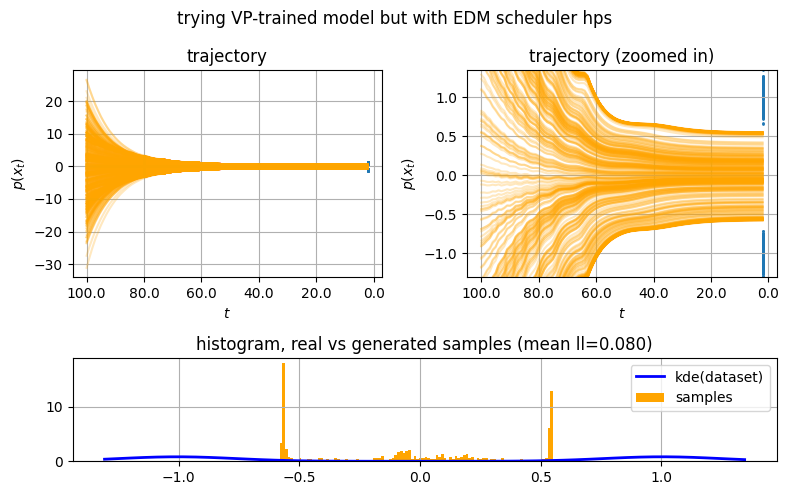

************************
  testing VE sampler...
************************


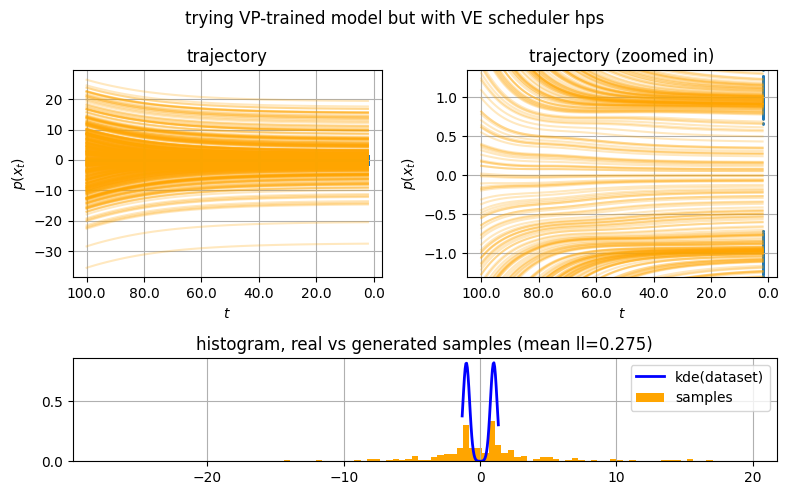

************************
  testing VP sampler...
************************


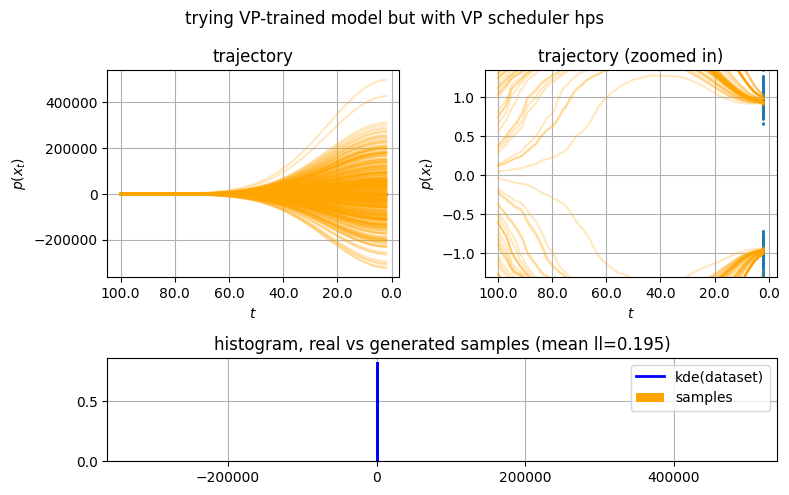

-----------------------------------


In [48]:
for option in ['ve', 'vp']:
    print(f"processing {option} ...")
    
    D = get_model(option=option, weights_file="weights/d_{}.pt".format(option))
    
    print("************************")
    print("  testing EDM sampler...")
    print("************************")
    
    extra_kwargs = {'use_heun': True}
    
    results_edm  = edm_generalised_deterministic_sampler(
        D, 
        # During EDM training we sample ln \sigma ~ N(-1.2, 1.2), setting \sigma_T = 10
        # seems reasonable here.
        x        = torch.randn((512,1)).normal_(0, 10.).cuda(), 
        timesteps= get_timesteps_edm(N=100, sigma_min=0.002, sigma_max=10.),
        sigma_fn = lambda t: t*1.0,
        s_fn     = lambda t: t*0 + 1,     # don't use ones_like here since we need autograd to work
        **extra_kwargs
    )
    fig=plot_trajectory_v2(
        results_edm, 
        plot2_ylim=(dataset.min(), dataset.max()),
        kde_data=(kde_xvals, kde_yvals),
        kde=kde,
        main_title=f"trying {option.upper()}-trained model but with EDM scheduler hps"
    )
    display(fig)
    plt.close(fig)
    
    print("************************")
    print("  testing VE sampler...")
    print("************************")
    
    results_ve = edm_generalised_deterministic_sampler(
        D,
        x          = torch.randn((512,1)).normal_(0, 10).cuda(), 
        timesteps  = get_timesteps_ve(N=100, s_min=0.02, s_max=10.),
        sigma_fn   = lambda t: torch.sqrt(t),
        s_fn       = lambda t: t*0 + 1,    # don't use ones_like here
        **extra_kwargs
    )
    fig=plot_trajectory_v2(
        results_ve, 
        plot2_ylim=(dataset.min(), dataset.max()),
        kde_data=(kde_xvals, kde_yvals),
        kde=kde,
        main_title=f"trying {option.upper()}-trained model but with VE scheduler hps"
    )
    display(fig)
    plt.close(fig)
    
    b_d, b_min = 19.9, 0.1
    print("************************")
    print("  testing VP sampler...")
    print("************************")
    
    results_vp = edm_generalised_deterministic_sampler(
        D, 
        x          = torch.randn((512,1)).normal_(0, 10).cuda(), 
        timesteps  = get_timesteps_vp(N=100),
        sigma_fn   = lambda t: torch.sqrt(torch.exp(0.5*b_d*(t**2) + b_min*t)-1),
        s_fn       = lambda t: 1.0 / torch.sqrt(torch.exp(0.5*b_d*(t**2) + b_min*t)),
        debug=False,
        **extra_kwargs
    )
    fig=plot_trajectory_v2(
        results_vp, 
        plot2_ylim=(dataset.min(), dataset.max()),
        kde_data=(kde_xvals, kde_yvals),
        kde=kde,
        main_title=f"trying {option.upper()}-trained model but with VP scheduler hps"
    )
    display(fig)
    plt.close(fig)
    
    print("-----------------------------------")
    
    #break
    
    

**Conclusion:**
- For a VE-trained model, using Algorithm 1 with EDM scheduler hps performs the best in terms of likelihood.
- For a VP-trained model, using Algorithm 1 with VE scheduler performs the best in terms of likelihood.

In [59]:
# Let's write an animated version just for fun

In [43]:
import matplotlib.gridspec as gridspec

def plot_trajectory_animated(
    traj,
    dataset,
    figsize=(8,5), 
    plot2_ylim=(-1, 1),
    max_len=100,
    alpha=0.25,
    main_title=None,
    debug=False
):

    # Create a figure
    fig = plt.figure(figsize=figsize)

    # Define a GridSpec with 2 rows and 2 columns
    gs = gridspec.GridSpec(1, 2)  # height_ratios adjust the row heights
    
    T = len(traj)
    bs = traj[0].size(0)
    
    #print(T, bs)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    axes = [ax1,ax2]
    titles = ["trajectory", "trajectory (zoomed in)"]
    
    for ax_idx in range(2):
        if debug:
            print(f"length of trajectories: {len(results[1])}")
            print(f"length of samples: {len(results[1][0])}")
        # For each element
        # traj[0][b], ... traj[-1][b]
        for b in range(bs):
            #print(b)
            #print(torch.stack([traj[t][b] for t in range(0,T) ]).cpu().numpy())
            axes[ax_idx].plot(
                torch.stack([traj[t][b] for t in range(0,T) ]).cpu().numpy(),
                c='orange',
                alpha=alpha
            )
        #axes[ax_idx].scatter(
        #    [T-1]*bs, 
        #    # traj[-1] -> the last timestep
        #    # traj[-1]
        #    traj[-1].cpu().numpy().flatten(),
        #    s=0.9
        #)
        axes[ax_idx].scatter([max_len-1]*len(dataset), dataset[:,0].cpu().numpy(), s=0.9)
        #axes[ax_idx].invert_xaxis()
        axes[ax_idx].set_xlim(0, max_len)
        axes[ax_idx].set_xlabel('$t$')
        axes[ax_idx].set_ylabel('$p(x_t)$')
        axes[ax_idx].set_title(titles[ax_idx])
        if ax_idx == 1:
            axes[ax_idx].set_ylim(*plot2_ylim)
        #axes[ax_idx].scatter([T-1]*len(dataset), dataset[:,0].cpu().numpy(), s=0.9)
        axes[ax_idx].grid()
        # reverse the x axis ticks as well
        axes[ax_idx].set_xticklabels(axes[ax_idx].get_xticks()[::-1])
    
        #print(T, max_len)
        fig.suptitle(f"iteration: {T} / {max_len}")

    # Adjust layout to avoid overlap
    fig.tight_layout()
    
    return fig

In [38]:
%%bash
#mkdir tmp

In [45]:
for t in range(1,100):
    tmpfig = plot_trajectory_animated(
        results_edm[1][-1][0:t], # without heun 
        dataset,
        #max_len=500,
        max_len=100,
        figsize=(8,3),
        plot2_ylim=(dataset.min(), dataset.max())
    )
    tmpfig.savefig(f"tmp/{str(t).zfill(3)}.png")
    plt.close(tmpfig)

/tmp/ipykernel_2161944/388480134.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[ax_idx].set_xticklabels(axes[ax_idx].get_xticks()[::-1])


In [ ]:
%%bash
cd tmp
rm out.mp4
ffmpeg -framerate 24 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

In [58]:
results_edm[1][0].shape

torch.Size([512, 1])

## old code (no longer used)

In [90]:
_="""from matplotlib import pyplot as plt
import numpy as np

def plot_trajectory(results, dataset):

    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes = axes.flatten()

    T = len(results[1])
    bs = len(results[0])

    dataset_min = dataset.min() - dataset.std()
    dataset_max = dataset.max() + dataset.std()
    titles = ["trajectory", "trajectory (zoomed in)"]

    for ax_idx in range(2):
        print(f"length of trajectories: {len(results[1])}")
        # For each element
        traj = results[1]
        # traj[0][b], ... traj[-1][b]
        for b in range(bs):
            #print(b)
            #print(torch.stack([traj[t][b] for t in range(0,T) ]).cpu().numpy())
            axes[ax_idx].plot(
                torch.stack([traj[t][b] for t in range(0,T) ]).cpu().numpy(),
                c='orange',
                alpha=0.25
            )
        axes[ax_idx].set_xlabel('$t$ for $x_t$')
        axes[ax_idx].set_ylabel('$p(x_T)$')
        axes[ax_idx].set_title(titles[ax_idx])
        if ax_idx == 1:
            axes[ax_idx].set_ylim(dataset_min, dataset_max)
        axes[ax_idx].scatter([T-1]*len(dataset), dataset[:,0].cpu().numpy(), s=0.9)
        axes[ax_idx].grid()

    fig.tight_layout()"""